In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from athena import Athena
import matplotlib.pyplot as plt

# How to Run Simulations with Athena

### First Step: Initialize Simulation Parameters

Athena enables you to simulate Single Cell CRISPR Screens. Before you can run simulations you need to provide Athena with simulation parameters most noteably: on target activity, off target activity, type of CRISPR pertubation, number of Transcription Factors (TFs), number of E-genes, number of kinases, and the number of signalling cascades you want to simulate. Additional parameters you can provide include the number of cells per condition to simulate to where directory to store simulation data.

It's important to note that when initializing the Athena class is when you pass the parameters to Athena. All methods afterwards do not require or do not take any parameters.

In [2]:
athena = Athena(tau=0.1,
                negenes=200,
                nkinases=15,
                ncascades=3, 
                ncpus=3, nbatches=1,
                ngrnas_per_target=1,
                ncells_per_condition=1000)
                # crispr_type='Knockout',


# athena.create_network()
# athena.initialize_kinetics()

Initiate Environmental Parameters...
Check the caches...
Setup Simulator Directory...
Check Network Parameters...
Check gRNA Parameters...
Check Simulation Parameters...
Check Downsampling Parameters...


### Second Step: Create Gene Regulatory Network and Signalling Cascade

Both Gene Regulator Networks and Signalling Cascades are created using Modular Sampling method originally developed by GeneNetWeaver. This modular sampling method allows us to capture the scale-free and modular nature of biologically networks in comparison to an other scale-free random sampling method. Thereby allowing us to better represent the flow between reactions that occurs in biological networks.

**No Parameters Avaliable**

In [3]:
athena.create_network()

Created Network...


### Third Step:  Initialize Reaction Kinectics

Next we need to initialize reaction kinetics of both our GRN and Signalling Cascade.

**No Parameters Avaliable**

In [4]:
athena.initialize_kinetics()

Initialized Kinetics...


### Fourth Step: Create Guide RNA Metadata

Creating gRNA Metadata and Perturbation Coefficient Matrix.

**Parameters Avaliable**

- crispr_type: The type of CRISPR perturbation that you want to simulate. Only three types of CRISPR perturbations are currently supported: Interference, Activation, and Knockout

In [5]:
athena.generate_grnas(crispr_type='Interference', on_target=0.0, off_target=0)
# print (sim_name, gene, gene_on_target, value, ko_combos[col])

100%|██████████| 26/26 [00:00<00:00, 61.75it/s] 


### Fifth Step:  Compile Reactions for Simulation

Once we have initialized the kinetics and create gRNA metadata we need to convert all of this information in complied affinity and propensity probability calculation. This is required for the novel GPU Based Gillespie Algorithm.

**No Parameters Avaliable**

In [6]:
athena.compiling()

Simulation: athena Starting to Processing Batch 0...
Simulation: athena Current Memory % Usage: 24.2 Finished Processing Batch 0...


### Sixith Step: Run Gillispie Tau Leaping Algorithm

Now that we have compiled the chemical reactions we can run our simulations. Athena uses a opencl implementation of the Gillespie Tau-Leaping Algorithm. Which means Athena is CPU and GPU compatible. However, for obvious reasons using a GPU dramatically increases the speed of any simulation you want to run.

**No Parameters Avaliable**

In [7]:
athena.run()

Batch For Loop:   0%|          | 0/1 [00:00<?, ?it/s]

Creating Command Queue...
Start Simulation...



Running Simulations Batch: 0: 100%|██████████| 3000/3000 [04:56<00:00, 10.11it/s]


### Seventh Step: Sample Cells and Downsample Counts

Now that we have simulated cells we can randomly sample our cells and downsample our cells mRNA counts. Athena downsamples simulated cells mRNA counts using the a reference single cell dataset to parameterize both the number of mRNAs the cell will have (also known as a cells library size) and probability that a given mRNA of a given gene is sampled. 

**Parameters Avaliable**

- ncells: number of cells you want to sample from simulated cells
- pop_fp: file path to a loom file that is scanpy compatible that contains single cell dataset. If provided will use the provided dataset to downsample counts instead of internal single cell populations.

In [8]:
cells_meta, gene_expr = athena.sample(ncells=1000, sim_fp='athena/results/simulated_counts.csv.gz')

Simulation: athena Sampling Cells...
Simulation: athena Sampling Molecules...
Sampling Probabilities...
Fetching Quantiles...
Reshape into Expression Matrix...
Downsampling Counts...


988it [00:00, 7544.12it/s]

Simulation: athena Caching....


### Checking Library Sizes

In [9]:
cells_meta['mat_lib_size'] = gene_expr.sum(axis=1)
cells_meta[['lib_size', 'mat_lib_size']]

lib_size  mat_lib_size
0      4655.0          4655
1      5260.0          5259
2      2037.0          2037
3     11213.0         11213
4      3948.0          3948
..        ...           ...
983    7204.0          7204
984   11336.0         11336
985    2789.0          2789
986    4734.0          4734
987    3528.0          3528

[988 rows x 2 columns]

# Visualizing Gene Expression of Gillespie SSA

Now that we conducted a simulation let's see the effects our perturbations have upon our target genes. As we can see when using a Knockout CRISPR type all perturbed cells have count of zero for our target gene. In addition, these perturbations dramatically alter the expression level of multiple genes demonstrating that our simulated cells have been perturbed.

In [10]:
cell_sim_meta = pd.read_csv(f'{athena.results_dir}/cell_metadata.csv.gz')
simulations = pd.read_csv(f'{athena.results_dir}/simulated_counts.csv.gz')

grna_meta = cell_sim_meta.drop_duplicates(subset=['sim_name']).copy()
grna_meta['perturbed_gene'] = grna_meta['sim_name'].apply(lambda x: x.split('-grna')[0])
genes_to_plot = list("mol_mrna_" + grna_meta['perturbed_gene'].loc[grna_meta.perturbed_gene != 'CTRL'].values)

In [11]:
df = {"mol_counts": [], "mol": [], "time_step": [], "sim_index": [], "perturbed_gene": []}

for index, row in grna_meta.iterrows():
    
    for gene in genes_to_plot:
        index_locs = cell_sim_meta.loc[cell_sim_meta.sim_i == row.sim_i].index.values
        sim = simulations[gene].iloc[index_locs]
        sim = sim.reset_index(drop=True)
        
        df['time_step'] = df['time_step'] + list(sim.index)
        df['mol_counts'] = df['mol_counts'] + list(sim.values)
        df['mol'] = df['mol'] + [gene] * len(list(sim.values))
        df['sim_index'] = df['sim_index'] + [row.sim_i] * len(list(sim.values))
        df['perturbed_gene'] = df['perturbed_gene'] + [row.perturbed_gene] * len(list(sim.values))
    
df = pd.DataFrame(df)

  0%|          | 0/26 [00:00<?, ?it/s]

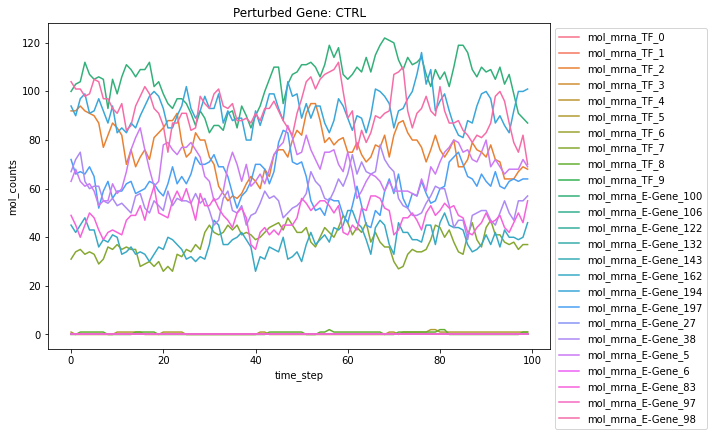

  4%|▍         | 1/26 [00:00<00:19,  1.28it/s]

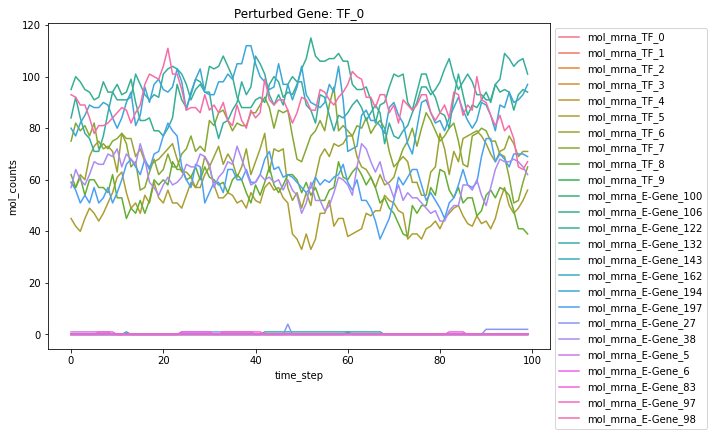

  8%|▊         | 2/26 [00:01<00:15,  1.54it/s]

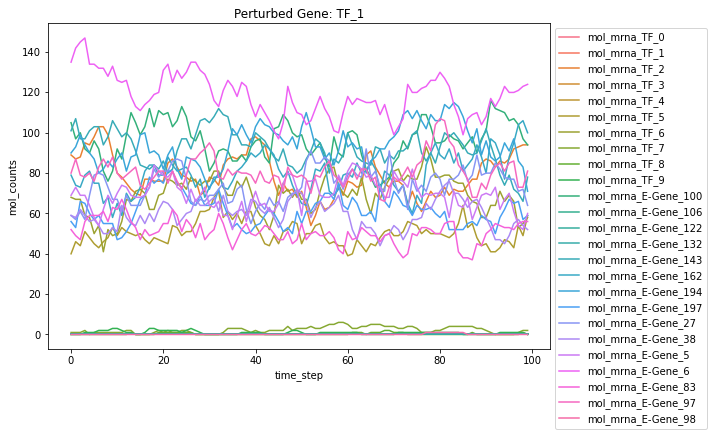

 12%|█▏        | 3/26 [00:01<00:13,  1.68it/s]

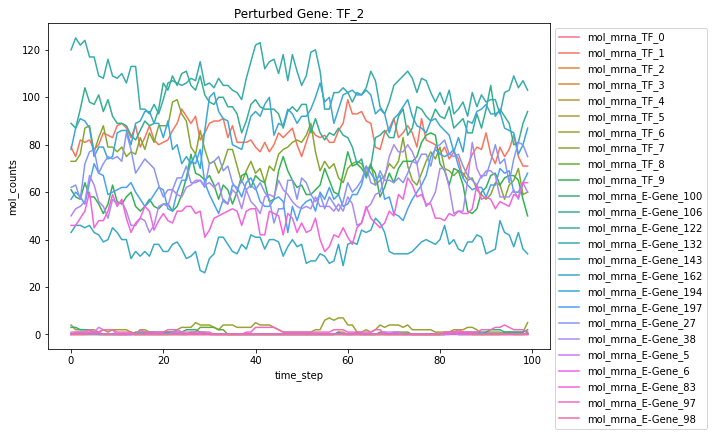

 15%|█▌        | 4/26 [00:02<00:12,  1.76it/s]

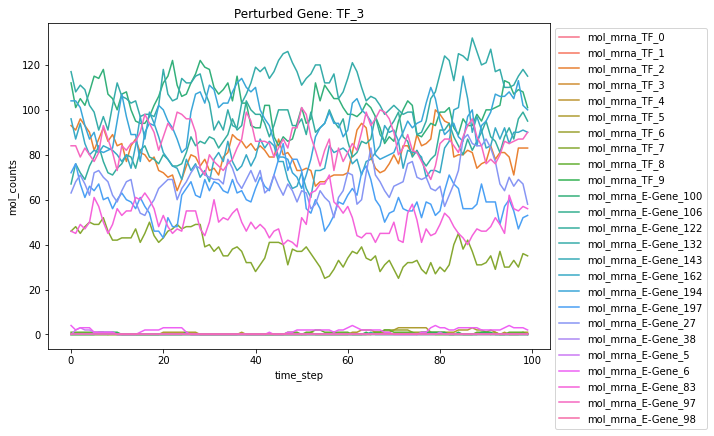

 19%|█▉        | 5/26 [00:02<00:11,  1.81it/s]

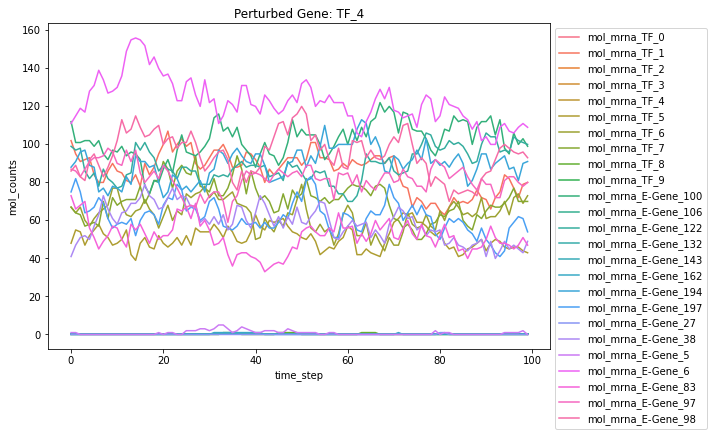

 23%|██▎       | 6/26 [00:03<00:10,  1.83it/s]

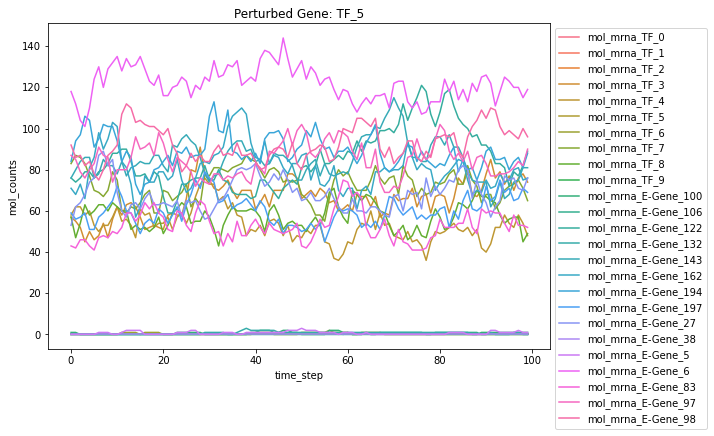

 27%|██▋       | 7/26 [00:03<00:10,  1.85it/s]

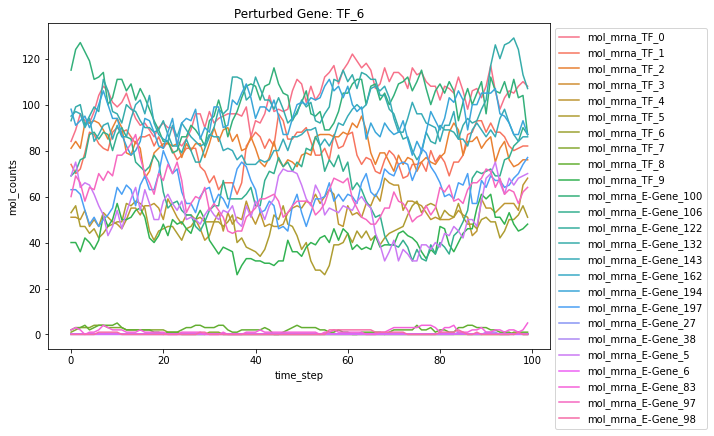

 31%|███       | 8/26 [00:04<00:10,  1.70it/s]

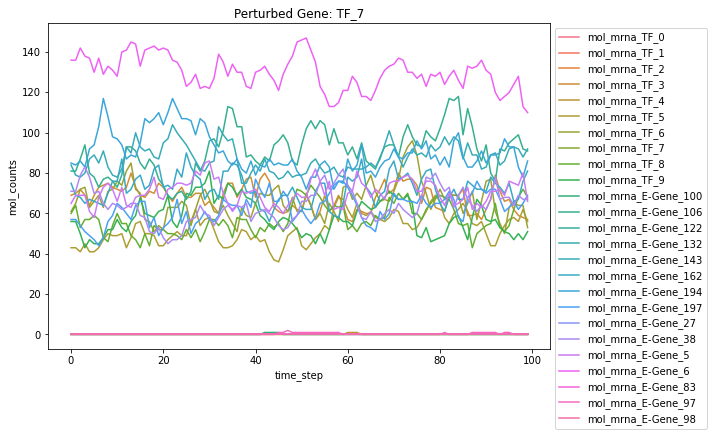

 35%|███▍      | 9/26 [00:05<00:09,  1.76it/s]

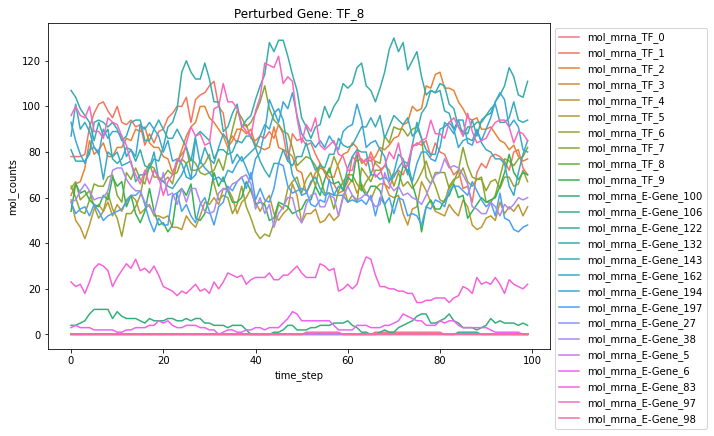

 38%|███▊      | 10/26 [00:05<00:08,  1.80it/s]

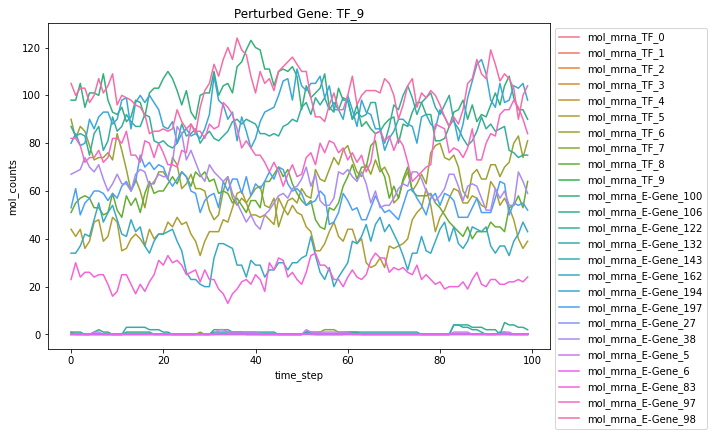

 42%|████▏     | 11/26 [00:06<00:08,  1.83it/s]

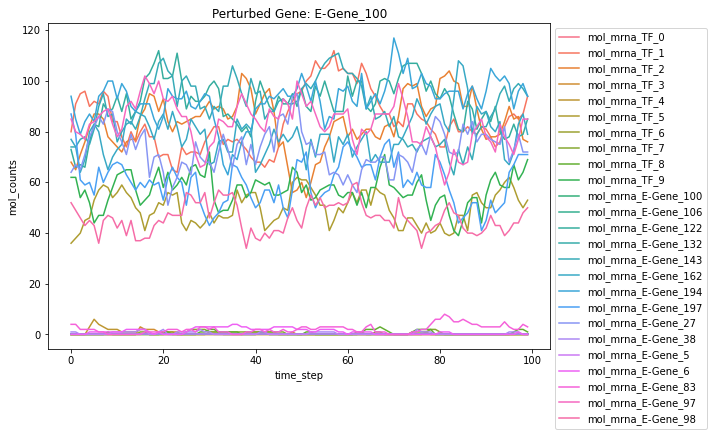

 46%|████▌     | 12/26 [00:06<00:07,  1.85it/s]

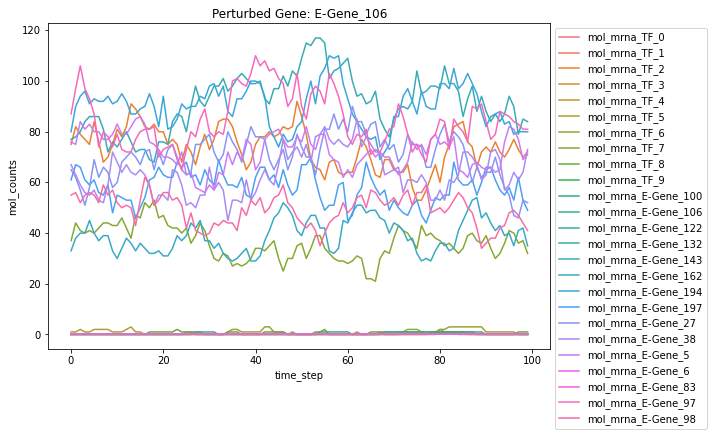

 50%|█████     | 13/26 [00:07<00:06,  1.87it/s]

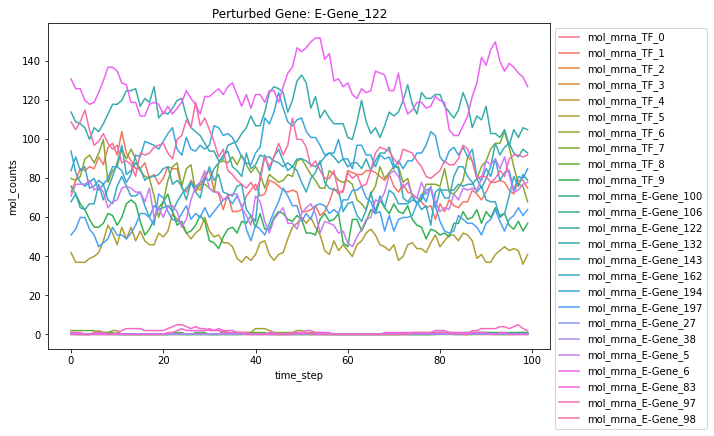

 54%|█████▍    | 14/26 [00:07<00:06,  1.88it/s]

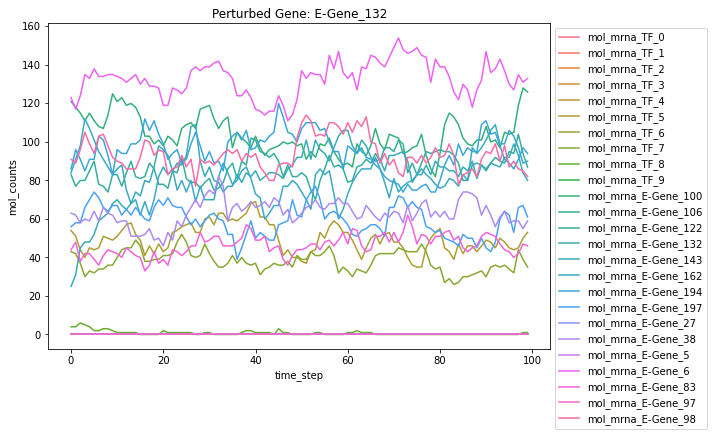

 58%|█████▊    | 15/26 [00:08<00:06,  1.72it/s]

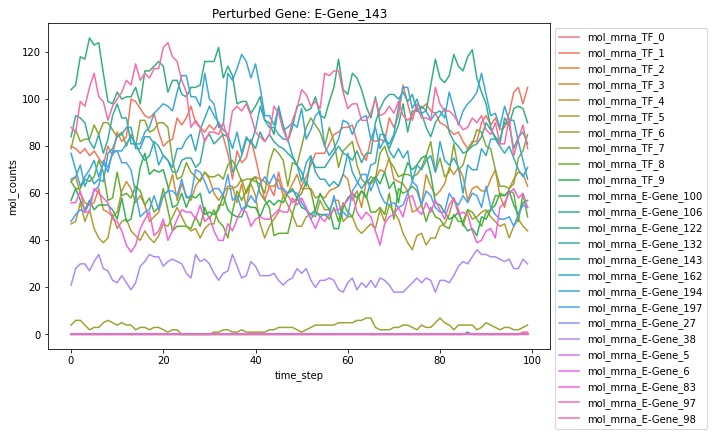

 62%|██████▏   | 16/26 [00:09<00:05,  1.77it/s]

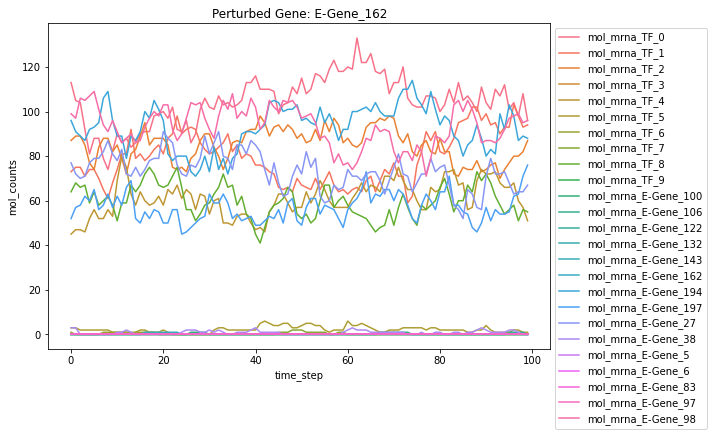

 65%|██████▌   | 17/26 [00:09<00:04,  1.82it/s]

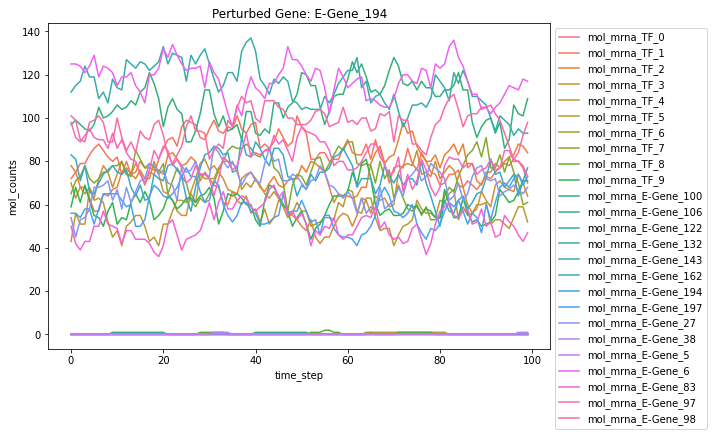

 69%|██████▉   | 18/26 [00:10<00:04,  1.84it/s]

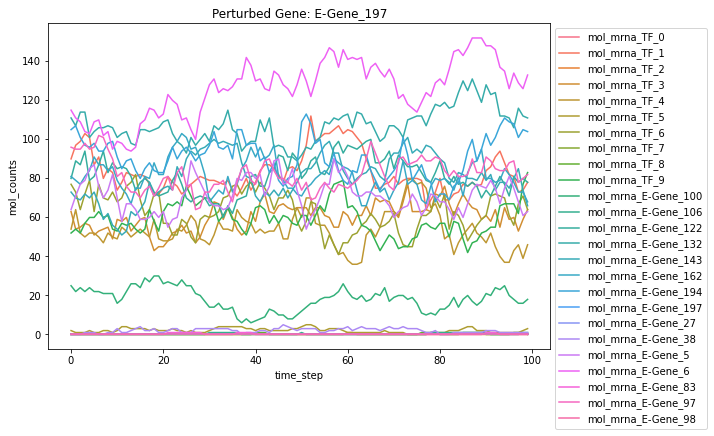

 73%|███████▎  | 19/26 [00:10<00:03,  1.85it/s]

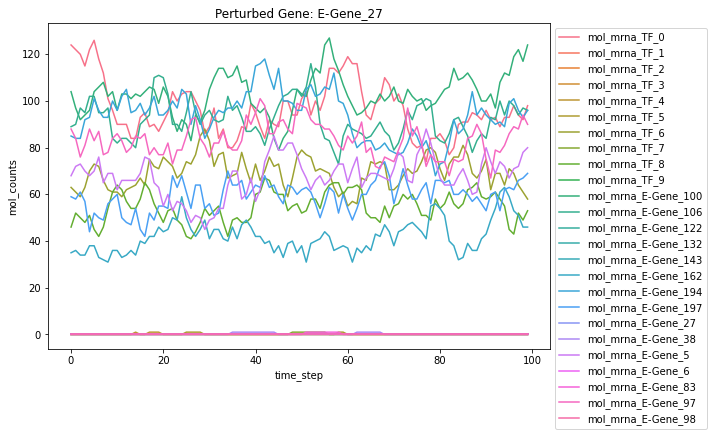

 77%|███████▋  | 20/26 [00:11<00:03,  1.87it/s]

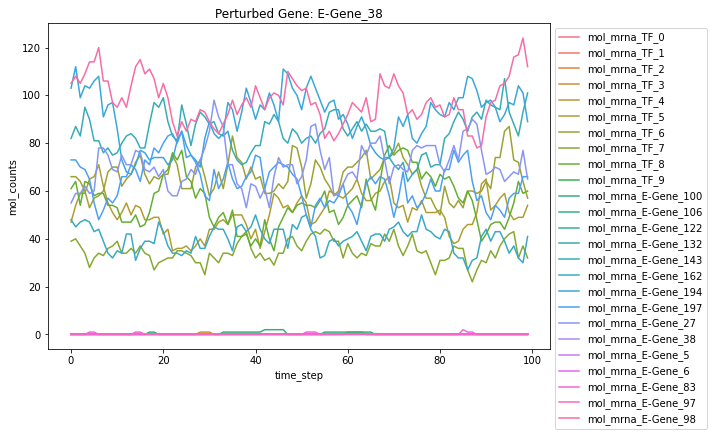

 81%|████████  | 21/26 [00:11<00:02,  1.88it/s]

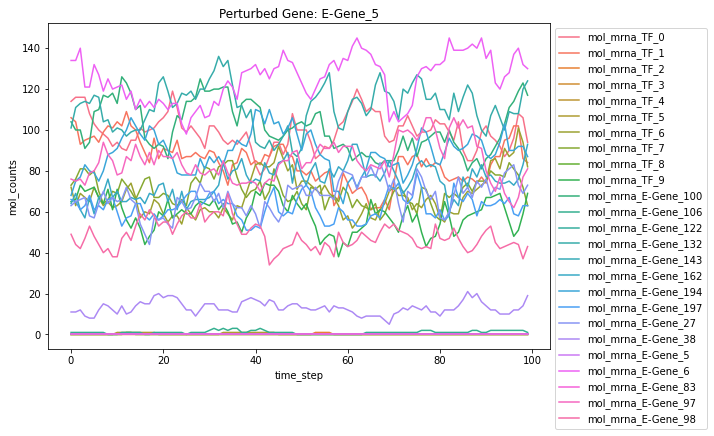

 85%|████████▍ | 22/26 [00:12<00:02,  1.72it/s]

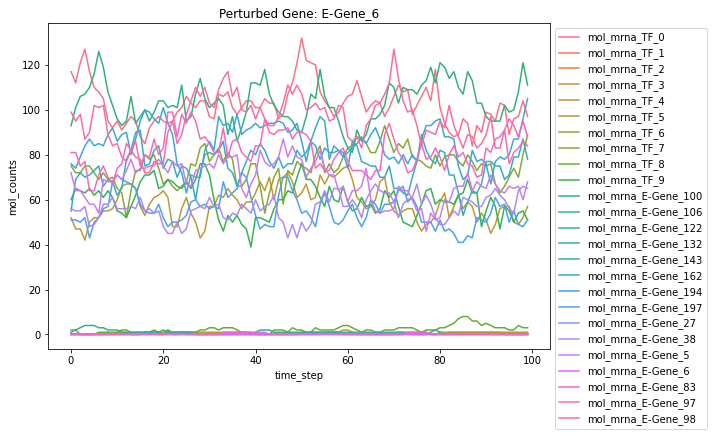

 88%|████████▊ | 23/26 [00:12<00:01,  1.77it/s]

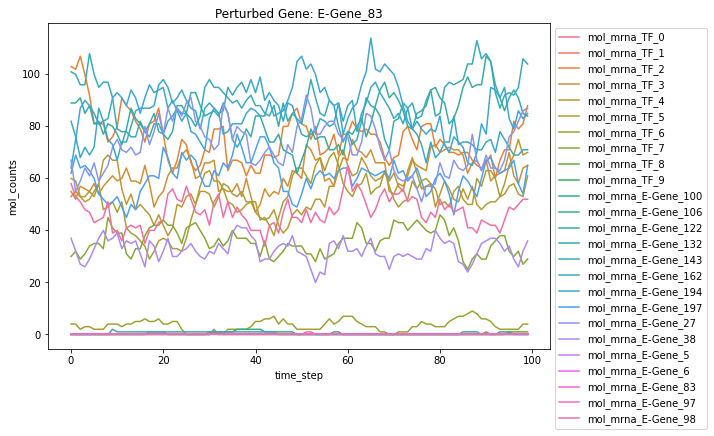

 92%|█████████▏| 24/26 [00:13<00:01,  1.81it/s]

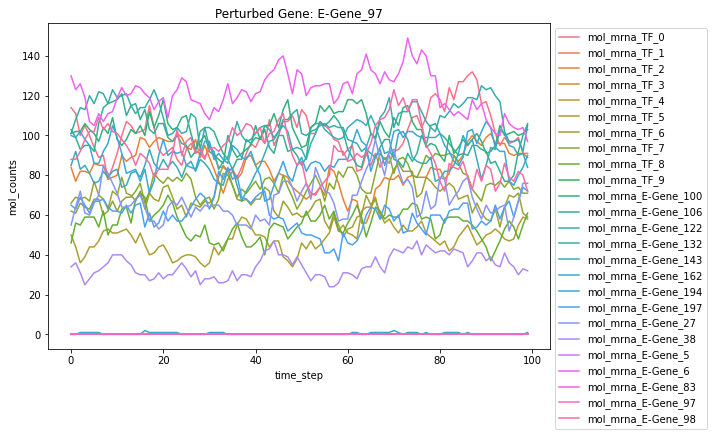

 96%|█████████▌| 25/26 [00:13<00:00,  1.84it/s]

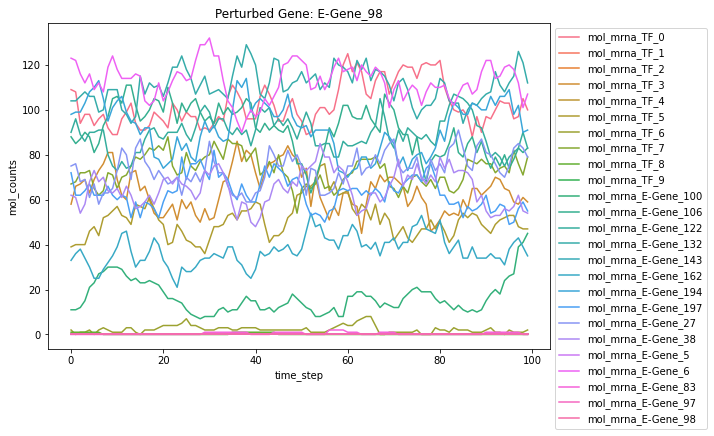

100%|██████████| 26/26 [00:14<00:00,  1.80it/s]


In [12]:
for gene in tqdm(df.perturbed_gene.unique()):
    gene_df = df.loc[df.perturbed_gene == gene]
    
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=gene_df, x='time_step', y='mol_counts', hue='mol')
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.title(f'Perturbed Gene: {gene}')
    plt.show()

In [13]:
for gene in tqdm(df.perturbed_gene.unique()):
    
    if gene == athena.ctrl_label:
        continue
    
    mol = 'mol_mrna_' + gene
    gene_df = df.loc[df.perturbed_gene == gene]
    mol_counts = gene_df.loc[gene_df.mol == mol, 'mol_counts'].unique()
    
    print (f"Perturbed Gene: {gene} Unique Counts: {mol_counts}")

100%|██████████| 26/26 [00:00<00:00, 198.70it/s]

Perturbed Gene: TF_0 Unique Counts: [0]
Perturbed Gene: TF_1 Unique Counts: [0]
Perturbed Gene: TF_2 Unique Counts: [0]
Perturbed Gene: TF_3 Unique Counts: [0]
Perturbed Gene: TF_4 Unique Counts: [0]
Perturbed Gene: TF_5 Unique Counts: [0]
Perturbed Gene: TF_6 Unique Counts: [0]
Perturbed Gene: TF_7 Unique Counts: [0]
Perturbed Gene: TF_8 Unique Counts: [0]
Perturbed Gene: TF_9 Unique Counts: [0]
Perturbed Gene: E-Gene_100 Unique Counts: [0]
Perturbed Gene: E-Gene_106 Unique Counts: [0]
Perturbed Gene: E-Gene_122 Unique Counts: [0]
Perturbed Gene: E-Gene_132 Unique Counts: [0]
Perturbed Gene: E-Gene_143 Unique Counts: [0]
Perturbed Gene: E-Gene_162 Unique Counts: [0]
Perturbed Gene: E-Gene_194 Unique Counts: [0]
Perturbed Gene: E-Gene_197 Unique Counts: [0]
Perturbed Gene: E-Gene_27 Unique Counts: [0]
Perturbed Gene: E-Gene_38 Unique Counts: [0]
Perturbed Gene: E-Gene_5 Unique Counts: [0]
Perturbed Gene: E-Gene_6 Unique Counts: [0]
Perturbed Gene: E-Gene_83 Unique Counts: [0]
Perturbed